In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def estimate_homography_ransac(points1, points2, ransac_threshold=3.0, ransac_iterations=1000):
    assert points1.shape == points2.shape, "Input point sets must have the same shape."

    # 将点坐标转换为二维数组
    points1 = points1.reshape(-1, 2)
    points2 = points2.reshape(-1, 2)

    # 使用 RANSAC 算法估计单应矩阵
    homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC, ransac_threshold, maxIters=ransac_iterations)

    return homography, mask

In [48]:
def rtl(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    #提取sift特征点
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)
    flann = cv2.FlannBasedMatcher()
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good_matches.append(m)

    match_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # 显示匹配结果
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, mask = estimate_homography_ransac(points2, points1)

    print("Estimated Homography:")
    print(homography)
    
    
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    # 使用单应矩阵计算变换后的图像尺寸
    corners1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1,1,2)
    corners2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1,1,2)
    corners2_ = cv2.perspectiveTransform(corners2, homography)
    
    corners = np.concatenate((corners1,corners2_), axis=0)
    [x_min, y_min] = np.int32(corners.min(axis=0).ravel() )
    [x_max, y_max] = np.int32(corners.max(axis=0).ravel())
    new_width = x_max - x_min
    new_height = y_max - y_min
    Ht = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    new_img = cv2.warpPerspective(img2, Ht.dot(homography), (new_width, new_height))
    for u in range(height1):
        for v in range(width1):
            if img1[u, v][0] != 0 or img1[u, v][1] != 0 or img1[u, v][2] != 0:
                new_img[u + -y_min, v + -x_min] = img1[u, v]

    return new_img

In [49]:
def ltr(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    #提取sift特征点
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)
    flann = cv2.FlannBasedMatcher()
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good_matches.append(m)

    match_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # 显示匹配结果
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, mask = estimate_homography_ransac(points1, points2)

    print("Estimated Homography:")
    print(homography)
    
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    # 使用单应矩阵计算变换后的图像尺寸
    corners1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1,1,2)
    corners1_ = cv2.perspectiveTransform(corners1, homography)
    corners2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1,1,2)
    
    corners = np.concatenate((corners1_,corners2), axis=0)
    [x_min, y_min] = np.int32(corners.min(axis=0).ravel() )
    [x_max, y_max] = np.int32(corners.max(axis=0).ravel() )
    new_width = x_max - x_min
    new_height = y_max - y_min

    Ht = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    new_img = cv2.warpPerspective(img1, Ht.dot(homography), (new_width, new_height))

    for u in range(height2):
        for v in range(width2):
            if img2[u, v][0] != 0 or img2[u, v][1] != 0 or img2[u, v][2] != 0:
                new_img[u + -y_min, v + -x_min] = img2[u, v]

    return new_img

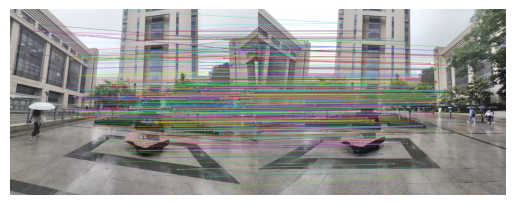

Estimated Homography:
[[ 1.74751979e+00  6.02292463e-04 -4.52170575e+02]
 [ 2.69103642e-01  1.42434324e+00 -1.97653354e+02]
 [ 5.99573863e-04  5.49758692e-06  1.00000000e+00]]


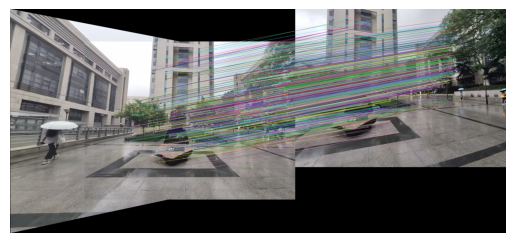

Estimated Homography:
[[ 3.91167678e-01 -1.45519654e-02  7.24499422e+02]
 [-2.20166324e-01  8.02084263e-01  2.85670266e+02]
 [-3.55406245e-04 -6.09406894e-07  1.00000000e+00]]


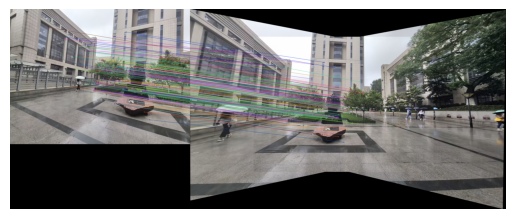

Estimated Homography:
[[ 5.11310617e+00  9.49891733e-02 -1.38746996e+03]
 [ 1.57849992e+00  2.98092077e+00 -6.66337243e+02]
 [ 2.41708856e-03  6.41707545e-05  1.00000000e+00]]


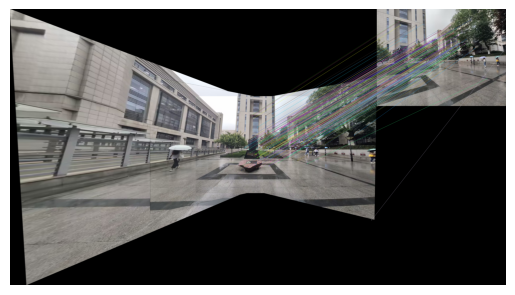

Estimated Homography:
[[-7.87934630e-01 -1.54139915e-02  2.27666442e+03]
 [-7.48382712e-01  7.17947799e-01  9.97190667e+02]
 [-5.74909775e-04 -4.87588981e-07  1.00000000e+00]]


True

In [50]:
img1_path = "1.jpg"
img2_path = "2.jpg"
img3_path = "3.jpg"
img4_path = "4.jpg"
img5_path = "5.jpg"

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
img3 = cv2.imread(img3_path)
img4 = cv2.imread(img4_path)
img5 = cv2.imread(img5_path)

img23 = ltr(img2, img3)
cv2.imwrite('img23.jpg', img23)
img234 = rtl(img23, img4)
cv2.imwrite('img234.jpg',img234)
img1234 = ltr(img1, img234)
cv2.imwrite('img1234.jpg',img1234)
img12345 = rtl(img1234, img5)
cv2.imwrite('img12345.jpg',img12345)







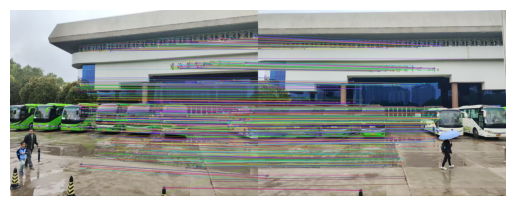

Estimated Homography:
[[ 1.49194062e+00 -1.46413114e-02 -4.82086664e+02]
 [ 1.74612129e-01  1.27764730e+00 -1.18901283e+02]
 [ 3.86758656e-04 -2.57493608e-05  1.00000000e+00]]


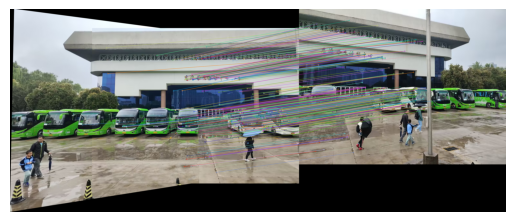

Estimated Homography:
[[ 2.85714533e-01  9.77147758e-03  9.74698840e+02]
 [-2.60355821e-01  8.06890870e-01  2.31216273e+02]
 [-3.93275409e-04 -1.72056962e-05  1.00000000e+00]]


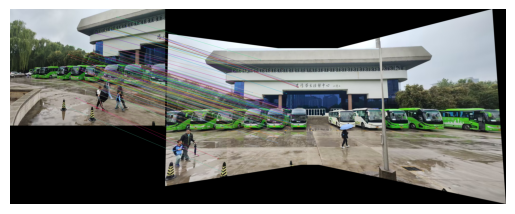

Estimated Homography:
[[ 3.92652216e+00 -2.21059834e-01 -1.49274742e+03]
 [ 1.38272984e+00  2.35219308e+00 -3.36839272e+02]
 [ 1.67110142e-03 -1.85809487e-04  1.00000000e+00]]


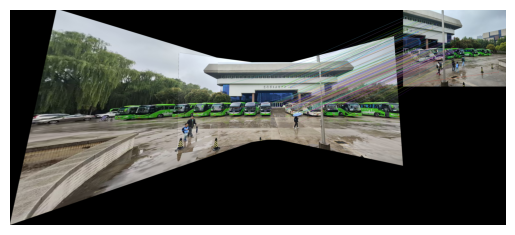

Estimated Homography:
[[-1.18362468e+00 -1.37175140e-02  3.33791710e+03]
 [-6.53265163e-01  8.19687768e-01  7.51725707e+02]
 [-5.65287172e-04 -1.04910929e-05  1.00000000e+00]]


True

In [51]:
img6_path = "6.jpg"
img7_path = "7.jpg"
img8_path = "8.jpg"
img9_path = "9.jpg"
img0_path = "0.jpg"
img6 = cv2.imread(img6_path)
img7 = cv2.imread(img7_path)
img8 = cv2.imread(img8_path)
img9 = cv2.imread(img9_path)
img0 = cv2.imread(img0_path)
img78 = ltr(img7, img8)
cv2.imwrite('img78.jpg', img78)             
img789 = rtl(img78, img9)
cv2.imwrite('img789.jpg', img789)
img6789 = ltr(img6, img789)
cv2.imwrite('img6789.jpg',img6789)
img67890 = rtl(img6789, img0)
cv2.imwrite('img67890.jpg',img67890)